In [1]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import collections
from copy import deepcopy
import time
import random
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

random.seed(42)
np.random.seed(42)
# sns.set(style='whitegrid', palette='muted', font_scale=1.5)
# rcParams['figure.figsize'] = 14, 8
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)  # If using CUDA

# Additional steps to ensure reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())
print(torch.__version__)

cuda
NVIDIA GeForce RTX 2070 SUPER
True
1.13.1


In [3]:
# 코랩에서 돌릴때 여기서부터
data_dir = "data"
train_X = pd.read_csv(os.path.join(data_dir,"train_X.csv")).drop(['Unnamed: 0'],axis=1)
train_y = pd.read_csv(os.path.join(data_dir,"train_y.csv")).drop(['Unnamed: 0'],axis=1)
val_X = pd.read_csv(os.path.join(data_dir,"val_X.csv")).drop(['Unnamed: 0'],axis=1)
val_y = pd.read_csv(os.path.join(data_dir,"val_y.csv")).drop(['Unnamed: 0'],axis=1)
test_X = pd.read_csv(os.path.join(data_dir,"test_X.csv")).drop(['Unnamed: 0'],axis=1)
test_y = pd.read_csv(os.path.join(data_dir,"test_y.csv")).drop(['Unnamed: 0'],axis=1)
tv_X = pd.concat([train_X, val_X], ignore_index=True)
tv_y = pd.concat([train_y, val_y], ignore_index=True)

In [4]:
typo_fix = ['isFlaggedFraud', 'trivialIsFraud', 'originRatio', 'destinationRatio',
       'isMerchant', 'originCount', 'destinationCount', 'type_CASH_IN',
       'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER',
       'amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest']
train_X.columns = typo_fix
val_X.columns = typo_fix
test_X.columns = typo_fix

In [5]:
print(len(train_X))
print(len(train_y))
print(len(val_X))
print(len(val_y))
print(len(test_X))
print(len(test_y))
print(len(tv_X))
print(len(tv_y))

3186492
3186492
1595351
1595351
1580777
1580777
4781843
4781843


In [6]:
train_X

,isFlaggedFraud,trivialIsFraud,originRatio,destinationRatio,isMerchant,originCount,destinationCount,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest
0,0,0.0,-2.850083,9.194276,1,1,1,0.0,0.0,0.0,1.0,0.0,9.194276,12.044359,11.984786,0.000000,0.000000
1,0,0.0,-2.432946,7.531166,1,1,1,0.0,0.0,0.0,1.0,0.0,7.531166,9.964112,9.872292,0.000000,0.000000
2,0,0.5,0.000000,5.204007,0,1,1,0.0,0.0,0.0,0.0,1.0,5.204007,5.204007,0.000000,0.000000,0.000000
3,0,0.5,0.000000,-4.756948,0,1,1,0.0,1.0,0.0,0.0,0.0,5.204007,5.204007,0.000000,9.960954,0.000000
4,0,0.0,-1.270070,9.364703,1,1,1,0.0,0.0,0.0,1.0,0.0,9.364703,10.634773,10.305174,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3186487,0,0.0,-2.856949,8.122496,1,1,1,0.0,0.0,0.0,1.0,0.0,8.122496,10.979445,10.920304,0.000000,0.000000
3186488,0,0.0,-1.516610,8.137583,1,1,1,0.0,0.0,0.0,1.0,0.0,8.137583,9.654193,9.406512,0.000000,0.000000
3186489,0,0.0,-2.724462,-6.753963,0,1,8,1.0,0.0,0.0,0.0,0.0,8.789633,11.514095,11.577606,15.543596,15.542429
3186490,0,0.0,-2.817071,9.291730,1,1,1,0.0,0.0,0.0,1.0,0.0,9.291730,12.108802,12.047165,0.000000,0.000000


In [7]:
val_X

,isFlaggedFraud,trivialIsFraud,originRatio,destinationRatio,isMerchant,originCount,destinationCount,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest
0,0,0.0,-1.091333,8.842877,1,1,1,0.0,0.0,0.0,1.0,0.0,8.842877,9.934211,9.525159,0.000000,0.000000
1,0,0.0,-0.715272,8.809887,1,1,1,0.0,0.0,0.0,1.0,0.0,8.809887,9.525159,8.853800,0.000000,0.000000
2,0,0.0,0.082838,8.936637,1,1,1,0.0,0.0,0.0,1.0,0.0,8.936637,8.853800,0.000000,0.000000,0.000000
3,0,0.0,2.209505,11.606491,0,1,1,1.0,0.0,0.0,0.0,0.0,11.606491,9.396986,11.710622,0.000000,0.000000
4,0,0.0,3.418480,8.360123,1,1,1,0.0,0.0,0.0,1.0,0.0,8.360123,4.941642,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595346,0,0.0,-2.794655,8.587570,1,1,1,0.0,0.0,0.0,1.0,0.0,8.587570,11.382224,11.319152,0.000000,0.000000
1595347,0,0.0,-1.294573,10.024579,1,1,1,0.0,0.0,0.0,1.0,0.0,10.024579,11.319152,10.998943,0.000000,0.000000
1595348,0,0.5,1.926218,-1.233553,0,1,10,0.0,1.0,0.0,0.0,0.0,11.827102,9.900884,0.000000,13.060655,13.316269
1595349,0,0.0,-4.079659,6.595002,1,1,1,0.0,0.0,0.0,1.0,0.0,6.595002,10.674660,10.657626,0.000000,0.000000


In [8]:
tv_X

,isFlaggedFraud,trivialIsFraud,originRatio,destinationRatio,isMerchant,originCount,destinationCount,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,0,0.0,-2.850083,9.194276,1,1,1,0.0,0.0,0.0,1.0,0.0,9.194276,12.044359,11.984786,0.000000,0.000000
1,0,0.0,-2.432946,7.531166,1,1,1,0.0,0.0,0.0,1.0,0.0,7.531166,9.964112,9.872292,0.000000,0.000000
2,0,0.5,0.000000,5.204007,0,1,1,0.0,0.0,0.0,0.0,1.0,5.204007,5.204007,0.000000,0.000000,0.000000
3,0,0.5,0.000000,-4.756948,0,1,1,0.0,1.0,0.0,0.0,0.0,5.204007,5.204007,0.000000,9.960954,0.000000
4,0,0.0,-1.270070,9.364703,1,1,1,0.0,0.0,0.0,1.0,0.0,9.364703,10.634773,10.305174,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4781838,0,0.0,-2.794655,8.587570,1,1,1,0.0,0.0,0.0,1.0,0.0,8.587570,11.382224,11.319152,0.000000,0.000000
4781839,0,0.0,-1.294573,10.024579,1,1,1,0.0,0.0,0.0,1.0,0.0,10.024579,11.319152,10.998943,0.000000,0.000000
4781840,0,0.5,1.926218,-1.233553,0,1,10,0.0,1.0,0.0,0.0,0.0,11.827102,9.900884,0.000000,13.060655,13.316269
4781841,0,0.0,-4.079659,6.595002,1,1,1,0.0,0.0,0.0,1.0,0.0,6.595002,10.674660,10.657626,0.000000,0.000000


In [9]:
train_y

,isFraud
0,0
1,0
2,1
3,1
4,0
...,...
3186487,0
3186488,0
3186489,0
3186490,0


In [10]:
val_y

,isFraud
0,0
1,0
2,0
3,0
4,0
...,...
1595346,0
1595347,0
1595348,0
1595349,0


In [11]:
tv_y

,isFraud
0,0
1,0
2,1
3,1
4,0
...,...
4781838,0
4781839,0
4781840,0
4781841,0


In [12]:
train_X

,isFlaggedFraud,trivialIsFraud,originRatio,destinationRatio,isMerchant,originCount,destinationCount,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest
0,0,0.0,-2.850083,9.194276,1,1,1,0.0,0.0,0.0,1.0,0.0,9.194276,12.044359,11.984786,0.000000,0.000000
1,0,0.0,-2.432946,7.531166,1,1,1,0.0,0.0,0.0,1.0,0.0,7.531166,9.964112,9.872292,0.000000,0.000000
2,0,0.5,0.000000,5.204007,0,1,1,0.0,0.0,0.0,0.0,1.0,5.204007,5.204007,0.000000,0.000000,0.000000
3,0,0.5,0.000000,-4.756948,0,1,1,0.0,1.0,0.0,0.0,0.0,5.204007,5.204007,0.000000,9.960954,0.000000
4,0,0.0,-1.270070,9.364703,1,1,1,0.0,0.0,0.0,1.0,0.0,9.364703,10.634773,10.305174,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3186487,0,0.0,-2.856949,8.122496,1,1,1,0.0,0.0,0.0,1.0,0.0,8.122496,10.979445,10.920304,0.000000,0.000000
3186488,0,0.0,-1.516610,8.137583,1,1,1,0.0,0.0,0.0,1.0,0.0,8.137583,9.654193,9.406512,0.000000,0.000000
3186489,0,0.0,-2.724462,-6.753963,0,1,8,1.0,0.0,0.0,0.0,0.0,8.789633,11.514095,11.577606,15.543596,15.542429
3186490,0,0.0,-2.817071,9.291730,1,1,1,0.0,0.0,0.0,1.0,0.0,9.291730,12.108802,12.047165,0.000000,0.000000


In [13]:
Fraud_idx = list(tv_y.iloc[np.where(tv_y['isFraud']==1)].index)
NotFraud_idx = list(tv_y.iloc[np.where(tv_y['isFraud']==0)].index)

In [14]:
print(len(Fraud_idx))
print(len(NotFraud_idx))

3749
4778094


In [15]:
print(len(tv_X))
print(len(tv_y))

4781843
4781843


In [16]:
tv_X

,isFlaggedFraud,trivialIsFraud,originRatio,destinationRatio,isMerchant,originCount,destinationCount,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,0,0.0,-2.850083,9.194276,1,1,1,0.0,0.0,0.0,1.0,0.0,9.194276,12.044359,11.984786,0.000000,0.000000
1,0,0.0,-2.432946,7.531166,1,1,1,0.0,0.0,0.0,1.0,0.0,7.531166,9.964112,9.872292,0.000000,0.000000
2,0,0.5,0.000000,5.204007,0,1,1,0.0,0.0,0.0,0.0,1.0,5.204007,5.204007,0.000000,0.000000,0.000000
3,0,0.5,0.000000,-4.756948,0,1,1,0.0,1.0,0.0,0.0,0.0,5.204007,5.204007,0.000000,9.960954,0.000000
4,0,0.0,-1.270070,9.364703,1,1,1,0.0,0.0,0.0,1.0,0.0,9.364703,10.634773,10.305174,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4781838,0,0.0,-2.794655,8.587570,1,1,1,0.0,0.0,0.0,1.0,0.0,8.587570,11.382224,11.319152,0.000000,0.000000
4781839,0,0.0,-1.294573,10.024579,1,1,1,0.0,0.0,0.0,1.0,0.0,10.024579,11.319152,10.998943,0.000000,0.000000
4781840,0,0.5,1.926218,-1.233553,0,1,10,0.0,1.0,0.0,0.0,0.0,11.827102,9.900884,0.000000,13.060655,13.316269
4781841,0,0.0,-4.079659,6.595002,1,1,1,0.0,0.0,0.0,1.0,0.0,6.595002,10.674660,10.657626,0.000000,0.000000


In [17]:
tv_y

,isFraud
0,0
1,0
2,1
3,1
4,0
...,...
4781838,0
4781839,0
4781840,0
4781841,0


In [18]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier #

from sklearn.model_selection import cross_val_score # 이값이 높은걸 선택하면 됨
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection

from sklearn.inspection import permutation_importance

from statistics import mean  #평균 0 표준편차1로 맞춰줌

In [19]:
models = { #모델이름: 모델
    "Ran":RandomForestClassifier(),
    "Log":LogisticRegression(),
    "XGB":XGBClassifier(),
}

param_grids = {
    "Ran":{"n_estimators":[100], "max_depth":[10]},
    "Log":{"max_iter":[20]},
    "XGB":{"max_depth":[10],"min_child_weight":[1]},
}

(10, 10, 24)


C:\Users\iguv\Anaconda3\envs\py38\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(10, 10, 36)
[[ 4.47111822e-02  1.79665899e+00 -1.08860568e+01 -2.26930099e+00
  -5.51008214e+00  3.88398034e-03  4.50710036e-01 -4.12277201e+00
   1.31354838e+00 -4.21121326e-01 -5.51008214e+00  2.23505842e+00
   1.09107149e+00  1.47775975e+01 -7.65600222e+00 -5.76272845e-01
  -5.78255444e+00]]
train acc:  0.9994197380693252
val acc:  0.9995994611844039
test acc  0.9981509093312972

train prec:  0.9349593495934959
val prec:  0.9698375870069605
test prec  0.9993519118600129

train recall:  0.34011090573012936
val recall:  0.4003831417624521
test recall  0.34543010752688175

train f1:  0.49878015722417995
val f1:  0.5667796610169492
test f1  0.5134010321291826
train run time : 11.7546


(-0.5, 0.5)

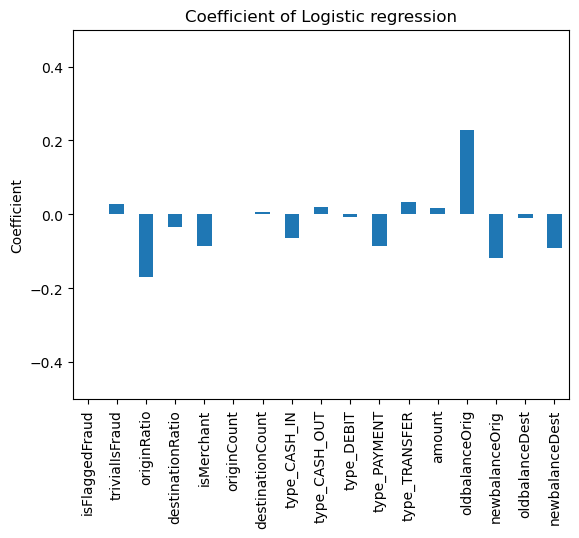

In [20]:
# Logistic
MmScaler = MinMaxScaler()

train_X_scaled = MmScaler.fit_transform(train_X)
val_X_sclaed = MmScaler.fit_transform(val_X)
test_X_scaled = MmScaler.fit_transform(test_X)

LG_start_time = time.time()
print(time.localtime()[3:6])
LGmodel=LogisticRegression(max_iter=20)
LGmodel.fit(train_X_scaled,train_y.to_numpy().ravel())
LG_end_time = time.time()
print(time.localtime()[3:6])
LG_run_time = LG_end_time - LG_start_time

LG_train_pred = np.round(LGmodel.predict(train_X_scaled))
LG_val_pred = np.round(LGmodel.predict(val_X_sclaed))
LG_test_pred = np.round(LGmodel.predict(test_X_scaled))

LG_train_acc = accuracy_score(train_y,LG_train_pred)
LG_train_prec = precision_score(train_y,LG_train_pred)
LG_train_recall = recall_score(train_y,LG_train_pred)
LG_train_f1 = f1_score(train_y,LG_train_pred)

LG_val_acc = accuracy_score(val_y,LG_val_pred)
LG_val_prec = precision_score(val_y,LG_val_pred)
LG_val_recall = recall_score(val_y,LG_val_pred)
LG_val_f1 = f1_score(val_y, LG_val_pred)

LG_test_acc = accuracy_score(test_y,LG_test_pred)
LG_test_prec = precision_score(test_y,LG_test_pred)
LG_test_recall = recall_score(test_y,LG_test_pred)
LG_test_f1 = f1_score(test_y, LG_test_pred)

LG_importance = LGmodel.coef_
print(LG_importance)

# LG report
print("train acc: ", LG_train_acc)
print("val acc: ", LG_val_acc)
print("test acc ", LG_test_acc)
print("")
print("train prec: ", LG_train_prec)
print("val prec: ", LG_val_prec)
print("test prec ", LG_test_prec)
print("")
print("train recall: ", LG_train_recall)
print("val recall: ", LG_val_recall)
print("test recall ", LG_test_recall)
print("")
print("train f1: ", LG_train_f1)
print("val f1: ", LG_val_f1)
print("test f1 ", LG_test_f1)
print("train run time : {:.4f}".format(LG_run_time))

# Logistic feature_importance (impurity based)
fig, ax = plt.subplots()
LG_importance_plt = pd.Series(LG_importance.ravel()/sum(np.abs(LG_importance.ravel())), index=train_X.columns)
LG_importance_plt.plot.bar(ax=ax)
ax.set_title("Coefficient of Logistic regression")
ax.set_ylabel("Coefficient")
ax.set_ylim(-0.5,0.5)

(10, 10, 45)
(10, 21, 45)
[3.23929351e-05 3.04624751e-03 4.44386701e-01 6.18721610e-02
 4.46273712e-05 9.41467544e-06 1.12682209e-02 9.38157217e-04
 1.69882138e-02 3.85236965e-06 7.27996649e-05 2.41571678e-02
 9.30568006e-02 5.98905715e-02 1.42868936e-01 1.88133004e-02
 1.22550435e-01]



train acc:  0.9999905852580204
val acc:  1.0
test acc  0.9999993673997029

train prec:  1.0
val prec:  1.0
test prec  1.0

train recall:  0.988909426987061
val recall:  1.0
test recall  0.9997759856630825

train f1:  0.9944237918215614
val f1:  1.0
test f1  0.9998879802845302

train run time : 660.1693


(0.0, 1.0)

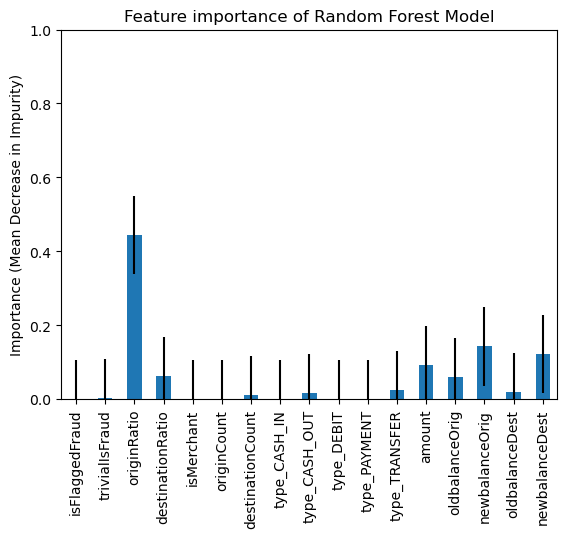

In [21]:
# Random Forest
RF_start_time = time.time()
print(time.localtime()[3:6])
RFmodel=RandomForestClassifier(max_depth=10, n_estimators=100)
RFmodel.fit(train_X,train_y.to_numpy().ravel())
RF_end_time = time.time()
print(time.localtime()[3:6])
RF_run_time = RF_end_time - RF_start_time

RF_train_pred = np.round(RFmodel.predict(train_X))
RF_val_pred = np.round(RFmodel.predict(val_X))
RF_test_pred = np.round(RFmodel.predict(test_X))

RF_train_acc = accuracy_score(train_y,RF_train_pred)
RF_train_prec = precision_score(train_y,RF_train_pred)
RF_train_recall = recall_score(train_y,RF_train_pred)
RF_train_f1 = f1_score(train_y,RF_train_pred)

RF_val_acc = accuracy_score(val_y,RF_val_pred)
RF_val_prec = precision_score(val_y,RF_val_pred)
RF_val_recall = recall_score(val_y,RF_val_pred)
RF_val_f1 = f1_score(val_y, RF_val_pred)

RF_test_acc = accuracy_score(test_y,RF_test_pred)
RF_test_prec = precision_score(test_y,RF_test_pred)
RF_test_recall = recall_score(test_y,RF_test_pred)
RF_test_f1 = f1_score(test_y, RF_test_pred)

RF_importance = RFmodel.feature_importances_
print(RF_importance)
print('\n\n')

# RF report
print("train acc: ", RF_train_acc)
print("val acc: ", RF_val_acc)
print("test acc ", RF_test_acc)
print("")
print("train prec: ", RF_train_prec)
print("val prec: ", RF_val_prec)
print("test prec ", RF_test_prec)
print("")
print("train recall: ", RF_train_recall)
print("val recall: ", RF_val_recall)
print("test recall ", RF_test_recall)
print("")
print("train f1: ", RF_train_f1)
print("val f1: ", RF_val_f1)
print("test f1 ", RF_test_f1)
print("")
print("train run time : {:.4f}".format(RF_run_time))



# RF feature_importance (impurity based)
fig, ax = plt.subplots()
RF_importance_std = np.std([imp for imp in RF_importance],axis=0)
RF_importance_plt = pd.Series(RF_importance, index=train_X.columns)
RF_importance_plt.plot.bar(yerr=RF_importance_std, ax=ax)
ax.set_title("Feature importance of Random Forest Model")
ax.set_ylabel("Importance (Mean Decrease in Impurity)")
ax.set_ylim(0,1)

(10, 22, 33)
(10, 27, 33)
[0.         0.00857566 0.12289619 0.01258371 0.         0.
 0.00208935 0.         0.04886575 0.         0.         0.00166336
 0.02082114 0.00816595 0.76322734 0.00560693 0.0055046 ]
train acc:  0.9999971755774061
val acc:  1.0
test acc  0.9999993673997029

train prec:  1.0
val prec:  1.0
test prec  1.0

train recall:  0.9966728280961183
val recall:  1.0
test recall  0.9997759856630825

train f1:  0.9983336419181633
val f1:  1.0
test f1  0.9998879802845302
train run time : 300.1686


(0.0, 1.0)

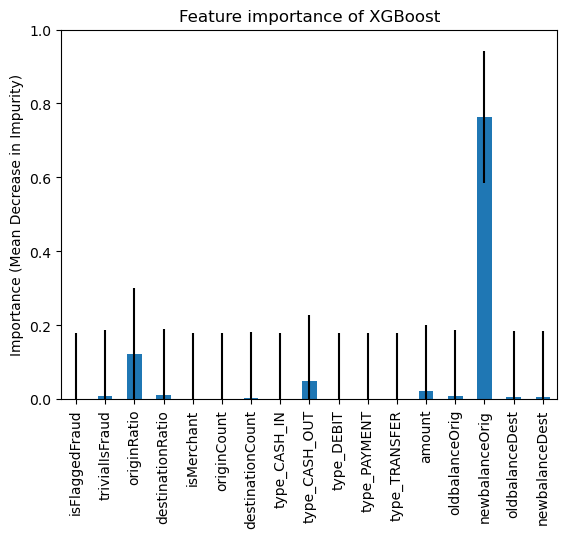

In [24]:
# XGBoost
XGB_start_time = time.time()
print(time.localtime()[3:6])
XGBmodel=XGBClassifier(max_depth=10, min_child_weight=1.0)
XGBmodel.fit(train_X,train_y.to_numpy().ravel())
XGB_end_time = time.time()
print(time.localtime()[3:6])
XGB_run_time = XGB_end_time - XGB_start_time

XGB_train_pred = np.round(XGBmodel.predict(train_X))
XGB_val_pred = np.round(XGBmodel.predict(val_X))
XGB_test_pred = np.round(XGBmodel.predict(test_X))

XGB_train_acc = accuracy_score(train_y,XGB_train_pred)
XGB_train_prec = precision_score(train_y,XGB_train_pred)
XGB_train_recall = recall_score(train_y,XGB_train_pred)
XGB_train_f1 = f1_score(train_y,XGB_train_pred)

XGB_val_acc = accuracy_score(val_y,XGB_val_pred)
XGB_val_prec = precision_score(val_y,XGB_val_pred)
XGB_val_recall = recall_score(val_y,XGB_val_pred)
XGB_val_f1 = f1_score(val_y, XGB_val_pred)

XGB_test_acc = accuracy_score(test_y,XGB_test_pred)
XGB_test_prec = precision_score(test_y,XGB_test_pred)
XGB_test_recall = recall_score(test_y,XGB_test_pred)
XGB_test_f1 = f1_score(test_y, XGB_test_pred)

XGB_importance = XGBmodel.feature_importances_
print(XGB_importance)

# XGB report
print("train acc: ", XGB_train_acc)
print("val acc: ", XGB_val_acc)
print("test acc ", XGB_test_acc)
print("")
print("train prec: ", XGB_train_prec)
print("val prec: ", XGB_val_prec)
print("test prec ", XGB_test_prec)
print("")
print("train recall: ", XGB_train_recall)
print("val recall: ", XGB_val_recall)
print("test recall ", XGB_test_recall)
print("")
print("train f1: ", XGB_train_f1)
print("val f1: ", XGB_val_f1)
print("test f1 ", XGB_test_f1)
print("train run time : {:.4f}".format(XGB_run_time))

# XGB feature_importance (impurity based)
fig, ax = plt.subplots()
XGB_importance_std = np.std([imp for imp in XGB_importance],axis=0)
XGB_importance_plt = pd.Series(XGB_importance, index=train_X.columns)
XGB_importance_plt.plot.bar(yerr=XGB_importance_std, ax=ax)
ax.set_title("Feature importance of XGBoost")
ax.set_ylabel("Importance (Mean Decrease in Impurity)")
ax.set_ylim(0,1)

# Focused model

In [25]:
train_X_selected = train_X[["originRatio", "newbalanceOrig"]]
val_X_selected = val_X[["originRatio", "newbalanceOrig"]]
test_X_selected = test_X[["originRatio","newbalanceOrig"]]

(10, 27, 42)
(10, 36, 41)
[0.74834917 0.25165083]
train acc:  0.9999924682064163
val acc:  0.999992478144308
test acc  0.9999715329866262

train prec:  1.0
val prec:  0.9961538461538462
test prec  0.9995478182229256

train recall:  0.9911275415896488
val recall:  0.9923371647509579
test recall  0.9903673835125448

train f1:  0.9955440029706647
val f1:  0.9942418426103647
test f1  0.994936423990098
train run time : 538.8624


(0.0, 1.0)

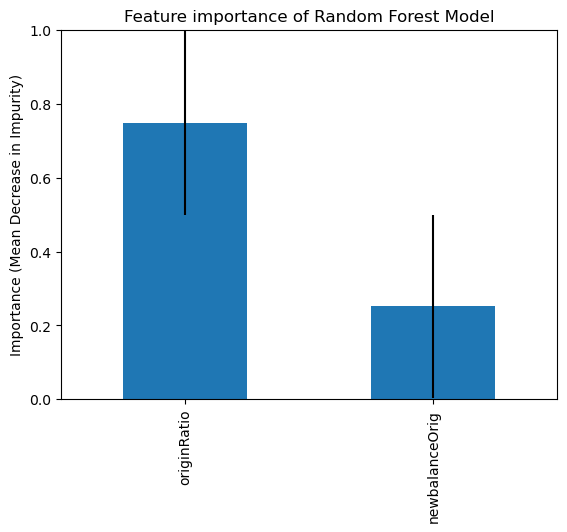

In [26]:
# Random Forest
fRF_start_time = time.time()
print(time.localtime()[3:6])
fRFmodel=RandomForestClassifier(max_depth=10, n_estimators=100)
fRFmodel.fit(train_X_selected,train_y.to_numpy().ravel())
fRF_end_time = time.time()
print(time.localtime()[3:6])
fRF_run_time = fRF_end_time - fRF_start_time

fRF_train_pred = np.round(fRFmodel.predict(train_X_selected))
fRF_val_pred = np.round(fRFmodel.predict(val_X_selected))
fRF_test_pred = np.round(fRFmodel.predict(test_X_selected))

fRF_train_acc = accuracy_score(train_y,fRF_train_pred)
fRF_train_prec = precision_score(train_y,fRF_train_pred)
fRF_train_recall = recall_score(train_y,fRF_train_pred)
fRF_train_f1 = f1_score(train_y,fRF_train_pred)

fRF_val_acc = accuracy_score(val_y,fRF_val_pred)
fRF_val_prec = precision_score(val_y,fRF_val_pred)
fRF_val_recall = recall_score(val_y,fRF_val_pred)
fRF_val_f1 = f1_score(val_y, fRF_val_pred)

fRF_test_acc = accuracy_score(test_y,fRF_test_pred)
fRF_test_prec = precision_score(test_y,fRF_test_pred)
fRF_test_recall = recall_score(test_y,fRF_test_pred)
fRF_test_f1 = f1_score(test_y, fRF_test_pred)

fRF_importance = fRFmodel.feature_importances_
print(fRF_importance)

# fRF report
print("train acc: ", fRF_train_acc)
print("val acc: ", fRF_val_acc)
print("test acc ", fRF_test_acc)
print("")
print("train prec: ", fRF_train_prec)
print("val prec: ", fRF_val_prec)
print("test prec ", fRF_test_prec)
print("")
print("train recall: ", fRF_train_recall)
print("val recall: ", fRF_val_recall)
print("test recall ", fRF_test_recall)
print("")
print("train f1: ", fRF_train_f1)
print("val f1: ", fRF_val_f1)
print("test f1 ", fRF_test_f1)
print("train run time : {:.4f}".format(fRF_run_time))


# fRF feature_importance (impurity based)
fig, ax = plt.subplots()
fRF_importance_std = np.std([imp for imp in fRF_importance],axis=0)
fRF_importance_plt = pd.Series(fRF_importance, index=train_X_selected.columns)
fRF_importance_plt.plot.bar(yerr=fRF_importance_std, ax=ax)
ax.set_title("Feature importance of Random Forest Model")
ax.set_ylabel("Importance (Mean Decrease in Impurity)")
ax.set_ylim(0,1)

(10, 37, 28)
(10, 40, 1)
[0.1695108 0.8304892]
train acc:  0.9999890161343572
val acc:  0.999992478144308
test acc  0.9999683699851403

train prec:  1.0
val prec:  1.0
test prec  1.0

train recall:  0.9870609981515711
val recall:  0.9885057471264368
test recall  0.9887992831541219

train f1:  0.9934883720930232
val f1:  0.9942196531791908
test f1  0.9943681009236315
train run time : 152.9192


(0.0, 1.0)

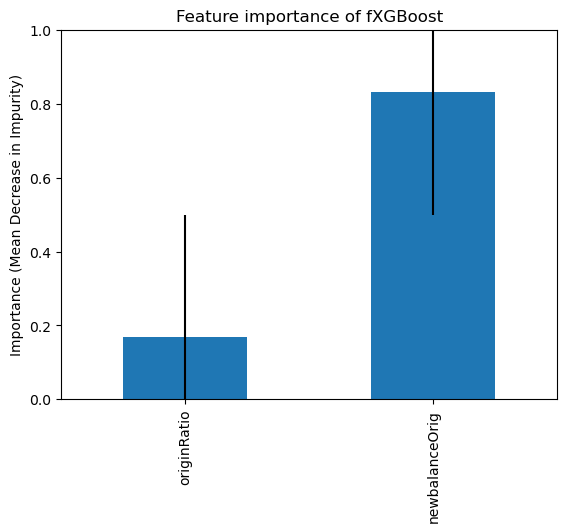

In [27]:
# fXGBoost
fXGB_start_time = time.time()
print(time.localtime()[3:6])
fXGBmodel=XGBClassifier(max_depth=10, min_child_weight=1.0)
fXGBmodel.fit(train_X_selected,train_y.to_numpy().ravel())
fXGB_end_time = time.time()
print(time.localtime()[3:6])
fXGB_run_time = fXGB_end_time - fXGB_start_time

fXGB_train_pred = np.round(fXGBmodel.predict(train_X_selected))
fXGB_val_pred = np.round(fXGBmodel.predict(val_X_selected))
fXGB_test_pred = np.round(fXGBmodel.predict(test_X_selected))

fXGB_train_acc = accuracy_score(train_y,fXGB_train_pred)
fXGB_train_prec = precision_score(train_y,fXGB_train_pred)
fXGB_train_recall = recall_score(train_y,fXGB_train_pred)
fXGB_train_f1 = f1_score(train_y,fXGB_train_pred)

fXGB_val_acc = accuracy_score(val_y,fXGB_val_pred)
fXGB_val_prec = precision_score(val_y,fXGB_val_pred)
fXGB_val_recall = recall_score(val_y,fXGB_val_pred)
fXGB_val_f1 = f1_score(val_y, fXGB_val_pred)

fXGB_test_acc = accuracy_score(test_y,fXGB_test_pred)
fXGB_test_prec = precision_score(test_y,fXGB_test_pred)
fXGB_test_recall = recall_score(test_y,fXGB_test_pred)
fXGB_test_f1 = f1_score(test_y, fXGB_test_pred)

fXGB_importance = fXGBmodel.feature_importances_
print(fXGB_importance)


# fXGB report
print("train acc: ", fXGB_train_acc)
print("val acc: ", fXGB_val_acc)
print("test acc ", fXGB_test_acc)
print("")
print("train prec: ", fXGB_train_prec)
print("val prec: ", fXGB_val_prec)
print("test prec ", fXGB_test_prec)
print("")
print("train recall: ", fXGB_train_recall)
print("val recall: ", fXGB_val_recall)
print("test recall ", fXGB_test_recall)
print("")
print("train f1: ", fXGB_train_f1)
print("val f1: ", fXGB_val_f1)
print("test f1 ", fXGB_test_f1)
print("train run time : {:.4f}".format(fXGB_run_time))

# fXGB feature_importance (impurity based)
fig, ax = plt.subplots()
fXGB_importance_std = np.std([imp for imp in fXGB_importance],axis=0)
fXGB_importance_plt = pd.Series(fXGB_importance, index=train_X_selected.columns)
fXGB_importance_plt.plot.bar(yerr=fXGB_importance_std, ax=ax)
ax.set_title("Feature importance of fXGBoost")
ax.set_ylabel("Importance (Mean Decrease in Impurity)")
ax.set_ylim(0,1)

(0.0, 1.0)

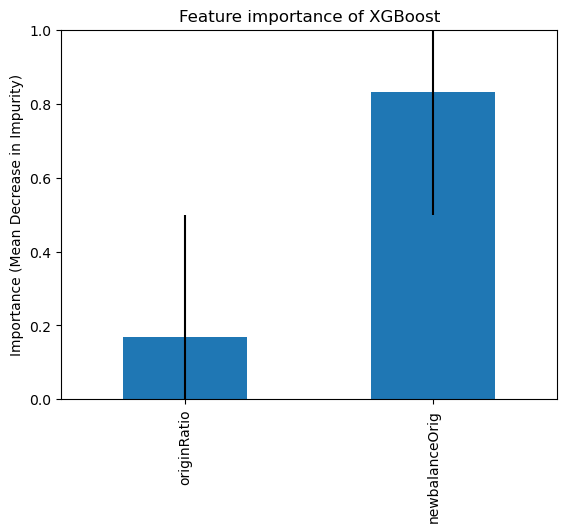

In [28]:
fig, ax = plt.subplots()
XGB_importance_std = np.std([imp for imp in fXGB_importance],axis=0)
XGB_importance_plt = pd.Series(fXGB_importance, index=train_X_selected.columns)
XGB_importance_plt.plot.bar(yerr=fXGB_importance_std, ax=ax)
ax.set_title("Feature importance of XGBoost")
ax.set_ylabel("Importance (Mean Decrease in Impurity)")
ax.set_ylim(0,1)

In [30]:
fRF_test_f1/RF_test_f1

0.9950478889714994

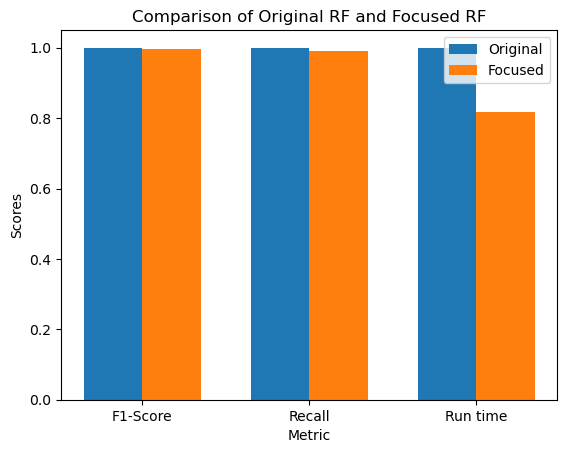

Run time percentage : 81.6(%)


In [31]:
models = ['F1-Score', 'Recall', 'Run time']
f1_scores = [1, 1, 1]
recalls = [fRF_test_f1/RF_test_f1,fRF_test_recall/RF_test_recall, fRF_run_time/RF_run_time]
bar_width = 0.35
x_pos = range(len(models))
plt.bar(x_pos, f1_scores, width=bar_width, label='Original')
plt.bar([x + bar_width for x in x_pos], recalls, width=bar_width, label='Focused')
plt.xlabel('Metric')
plt.ylabel('Scores')
plt.title('Comparison of Original RF and Focused RF')
plt.xticks([x + bar_width/2 for x in x_pos], models)
plt.legend()
plt.show()
print("Run time percentage : {:.1f}(%)".format(fRF_run_time/RF_run_time*100))

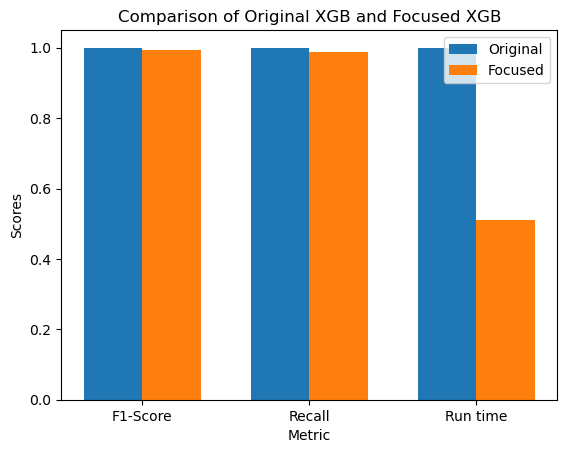

Run time percentage : 50.9(%)


In [32]:
models = ['F1-Score', 'Recall', 'Run time']
f1_scores = [1, 1, 1]
recalls = [fXGB_test_f1/XGB_test_f1,fXGB_test_recall/XGB_test_recall, fXGB_run_time/XGB_run_time]
bar_width = 0.35
x_pos = range(len(models))
plt.bar(x_pos, f1_scores, width=bar_width, label='Original')
plt.bar([x + bar_width for x in x_pos], recalls, width=bar_width, label='Focused')
plt.xlabel('Metric')
plt.ylabel('Scores')
plt.title('Comparison of Original XGB and Focused XGB')
plt.xticks([x + bar_width/2 for x in x_pos], models)
plt.legend()
plt.show()
print("Run time percentage : {:.1f}(%)".format(fXGB_run_time/XGB_run_time*100))

In [ ]:
# data_dir = "data"
# train_X = pd.read_csv(os.path.join(data_dir,"train_X.csv")).drop(['Unnamed: 0'],axis=1)
# train_y = pd.read_csv(os.path.join(data_dir,"train_y.csv")).drop(['Unnamed: 0'],axis=1)
# val_X = pd.read_csv(os.path.join(data_dir,"val_X.csv")).drop(['Unnamed: 0'],axis=1)
# val_y = pd.read_csv(os.path.join(data_dir,"val_y.csv")).drop(['Unnamed: 0'],axis=1)
# test_X = pd.read_csv(os.path.join(data_dir,"test_X.csv")).drop(['Unnamed: 0'],axis=1)
# test_y = pd.read_csv(os.path.join(data_dir,"test_y.csv")).drop(['Unnamed: 0'],axis=1)
# # tv_X = pd.concat([train_X, val_X], ignore_index=True)
# # tv_y = pd.concat([train_y, val_y], ignore_index=True)


# typo_fix = ['isFlaggedFraud', 'trivialIsFraud', 'originRatio', 'destinationRatio',
#        'isMerchant', 'originCount', 'destinationCount', 'type_CASH_IN',
#        'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER',
#        'amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest',
#        'newbalanceDest']
# train_X.columns = typo_fix
# val_X.columns = typo_fix
# test_X.columns = typo_fix

In [ ]:
# ## MINI
# MINI_LENGTH = 10000
# train_X = train_X[:MINI_LENGTH]
# train_y = train_y[:MINI_LENGTH]
# val_X = val_X[:MINI_LENGTH]
# val_y = val_y[:MINI_LENGTH]
# test_X = test_X[:MINI_LENGTH]
# test_y = test_y[:MINI_LENGTH]

# print(len(train_X))
# print(len(train_y))
# print(len(val_X))
# print(len(val_y))
# print(len(test_X))
# print(len(test_y))

In [ ]:
col_num = len(train_X.columns)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self,input_layers):
        
        super(Autoencoder, self).__init__()
        self.input_layers = input_layers
        
        self.encoder = nn.Sequential(
            nn.Linear(self.input_layers, self.input_layers//2),
            nn.Tanh(),
            nn.Linear(self.input_layers//2, self.input_layers//4),
            nn.LeakyReLU(),
            )
        
        self.decoder = nn.Sequential(
           nn.Linear(self.input_layers//4, self.input_layers//2),
           nn.Tanh(),
           nn.Linear(self.input_layers//2, self.input_layers),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
train_X_nonanomalous = train_X.iloc[np.where(train_y['isFraud']==0)]
train_X_nonanomalous = torch.tensor(train_X_nonanomalous.values, dtype=torch.float32)
train_X = torch.tensor(train_X.values, dtype=torch.float32)
train_y = torch.tensor(train_y.values, dtype=torch.float32)
val_X = torch.tensor(val_X.values, dtype=torch.float32)
val_y = torch.tensor(val_y.values, dtype=torch.float32)
test_X = torch.tensor(test_X.values, dtype=torch.float32)
test_y = torch.tensor(test_y.values, dtype=torch.float32)
len(train_X_nonanomalous)

In [ ]:
num_epochs = 50
minibatch_size = 32

In [ ]:
train_loader = data_utils.DataLoader(train_X_nonanomalous, batch_size=minibatch_size, shuffle=True)
train_analyze_loader = data_utils.DataLoader(train_X, batch_size=1, shuffle=False)
valid_loader = data_utils.DataLoader(val_X,  batch_size=1, shuffle=False)
test_loader = data_utils.DataLoader(test_X, batch_size=1, shuffle=False)

In [ ]:
def RUNAE(lr):
    
    model = Autoencoder(col_num).to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=10e-05)
    
    history = {}
    history['train_loss'] = []
    history['test_loss'] = []

    for epoch in range(num_epochs):
        h = np.array([])
        for data in train_loader:
            data = data.to(device)
            output = model(data)
            loss = criterion(output, data)
            h = np.append(h, loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        mean_loss = np.mean(h)
        print('epoch [{}/{}], loss:{:.4f}'
              .format(epoch + 1, num_epochs, mean_loss))
        history['train_loss'].append(mean_loss)

    model_name = 'credit_card_model_learningrate'+str(lr)
    torch.save(model.state_dict(), model_name+'.pth')
    
    
    
    pred_losses = {'pred_loss' : []}
    model.eval()
    with torch.no_grad():
        for data in train_analyze_loader:
            inputs = data.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs).data.item()
            pred_losses['pred_loss'].append(loss)
    
    reconstructionErrorDF = pd.DataFrame(pred_losses)
    reconstructionErrorDF['Class'] = train_y
    
    
    
    fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
    roc_auc_train = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc_train)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig(model_name+'_train.png')
    plt.show();
    
    
    pred_losses = {'pred_loss' : []}
    model.eval()
    with torch.no_grad():
        for data in valid_loader:
            inputs = data.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs).data.item()
            pred_losses['pred_loss'].append(loss)
 
    reconstructionErrorDF = pd.DataFrame(pred_losses)
    reconstructionErrorDF['Class'] = val_y
    
    
    fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
    roc_auc_val = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc_val)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig(model_name+'_val.png')
    plt.show();
    
    return roc_auc_train,roc_auc_val

In [ ]:
LRS = [0.0001,0.0003,0.0005,0.001,0.003,0.005,0.01,0.03]

In [ ]:
Results=[]
for test_lr in LRS:
    test_results = [test_lr]
    st = time.time()
    train_scores,val_scores = RUNAE(test_lr)
    et = time.time()
    test_results.append(train_scores)
    test_results.append(val_scores)
    test_results.append(et-st)
    Results.append(test_results)

In [ ]:
Result_outputs = pd.DataFrame(Results)
Result_outputs.columns = ['learning_rate','train_AUC','valid_AUC','run_time' ]
Result_outputs.to_csv("deeplearningresults.csv")

In [ ]:
final_test_model = Autoencoder(col_num).to(device)

In [ ]:
model_name = 'credit_card_model_learningrate0.001.pth'
final_test_model.load_state_dict(torch.load(model_name))

In [ ]:
criterion = nn.MSELoss().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=10e-05)

pred_losses = {'pred_loss' : []}
final_test_model.eval()
with torch.no_grad():
    for data in test_loader:
        inputs = data.to(device)
        outputs = final_test_model(inputs)
        loss = criterion(outputs, inputs).data.item()
        pred_losses['pred_loss'].append(loss)

reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = test_y

fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
roc_auc_val = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc_val)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(model_name+'_test.png')
plt.show();